<a href="https://colab.research.google.com/github/amandaswens/DSPS_ASwenson/blob/main/HW6/HW6_Second_Half_fitlinetogrbafterglow_mcmc_instructions_dsps25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [4]:
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pylab as plt
import scipy as sp
# you will need more imports, put them here


# HW part 1

## Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [5]:
# data is called grb050525A.csv in the data folder in the DSPS_FBianco repo
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/refs/heads/main/data/grb050525A.csv")
grbAG.head()


,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


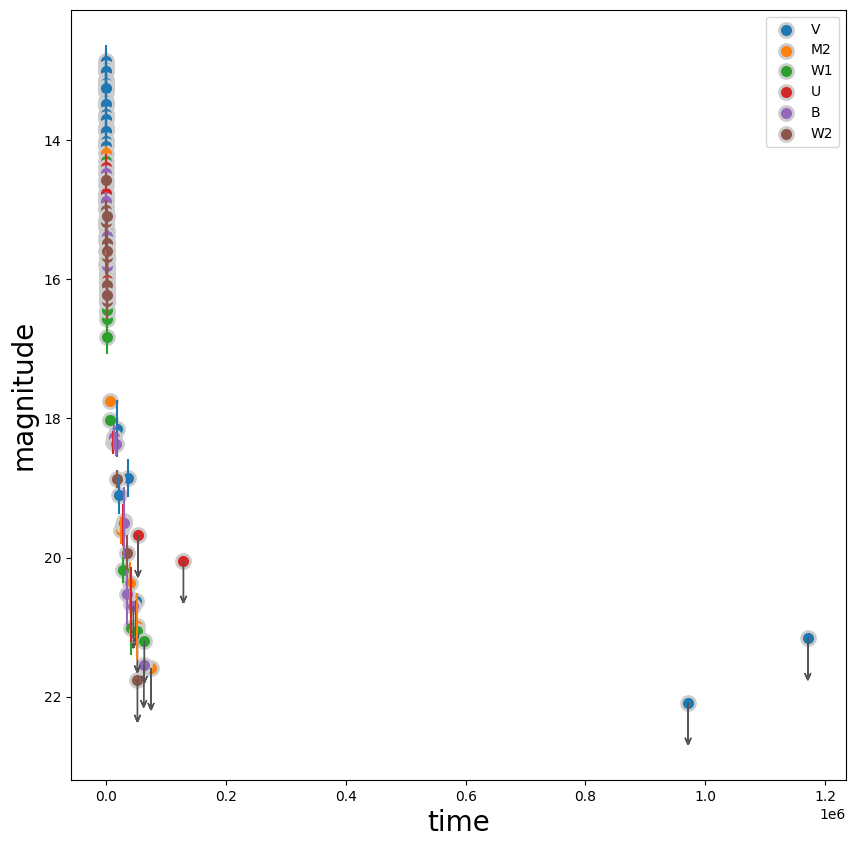

In [6]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
ax.yaxis.set_inverted(True)  # inverted axis with autoscaling
#pl.ylim(24,11.7) #simpler, less elegant - still does the trick
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);

## Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [7]:
grbAG["logtime"] = np.log10(grbAG["time"])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


## Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

In [8]:
def plotlogtime(df, models=[]):
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  ax.yaxis.set_inverted(True)  # inverted axis with autoscaling
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time", fontsize=20)
  return ax

<Axes: xlabel='log time', ylabel='magnitude'>

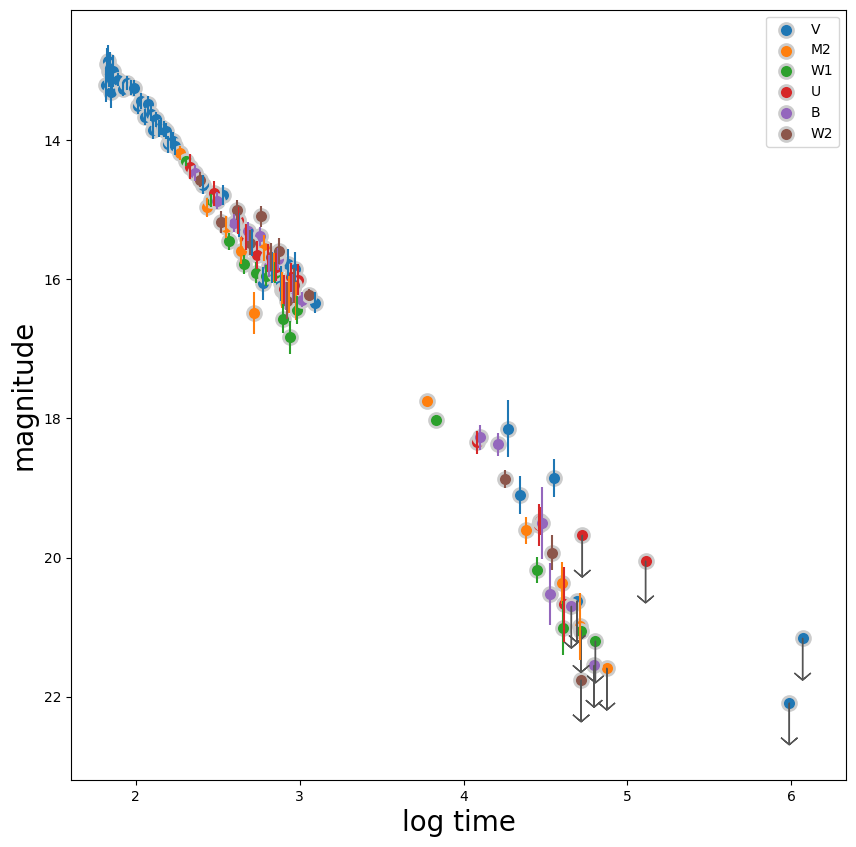

In [9]:
plotlogtime(grbAG)

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

## Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [10]:
grbAGnouplim =  grbAG[grbAG["upperlimit"] == 0]# remove the upper limits from the dataframe to simplify the analysis

In [11]:
x = grbAGnouplim.logtime.values
#pick a function to expand the axis
#option 1
X = np.c_[np.ones((len(grbAGnouplim), 1)),x]
#option 2 np.dstack((np.ones((X.shape[0])) ,X))


y = grbAGnouplim.mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [12]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


## Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```.
To remove the upper limits you can "broadcast" the data: in pandas that looks like

```grbAG.loc[grbAG.upperlimit == 0]```



In [13]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
lr = LinearRegression()
lr.fit(X, y)
print(f"slope {lr.coef_[1]:.2f} and intercept {lr.intercept_:.2f}")

slope 2.51 and intercept 8.58


## Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 and L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [14]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def line(intercept, slope, x):
    '''returns a line
    args:
    intercept: float
    slope: float
    x: array-like of exogenous variables
    '''
    return intercept + slope * x

def l1(args, x, y):
    '''l1 target function: returns value of l1 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L1 abs value of difference between prediction and data squared
    '''
    a, b = args
    return np.sum(np.abs(line(a, b, x) - y))


initialGuess = (2, 8)

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 26.30332889501873
        x: [ 8.225e+00  2.641e+00]
      nit: 14
      jac: [-1.254e-01 -2.083e+00]
 hess_inv: [[ 2.054e-02 -4.529e-03]
            [-4.529e-03  1.001e-03]]
     nfev: 300
     njev: 96

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64


In [15]:

def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    a, b = args
    return np.sum((line(a, b, x) - y)**2)


initialGuess = (2, 8)

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.825987500725498
        x: [ 8.583e+00  2.512e+00]
      nit: 5
      jac: [-1.192e-07 -3.576e-07]
 hess_inv: [[ 6.254e-02 -2.030e-02]
            [-2.030e-02  7.114e-03]]
     nfev: 21
     njev: 7

best fit parameters from the minimization of L2: slope 8.58, intercept 2.51


In [16]:
l2?

In [17]:
l1?

## Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [18]:
def chi2(args, x, y, s):
    a, b = args
    return np.sum((line(a, b, x) - y)**2 / s**2)


x = grbAGnouplim.logtime.values
y = grbAGnouplim.mag.values
s = grbAGnouplim.magerr.values

initialGuess = 8, 2

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 317.4206698013056
        x: [ 8.599e+00  2.480e+00]
      nit: 7
      jac: [-1.907e-05 -1.526e-05]
 hess_inv: [[ 3.314e-03 -2.853e-03]
            [-2.853e-03  2.473e-03]]
     nfev: 125
     njev: 38

best fit parameters from the minimization of the chi squared: slope 8.60, intercept 2.48


## Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


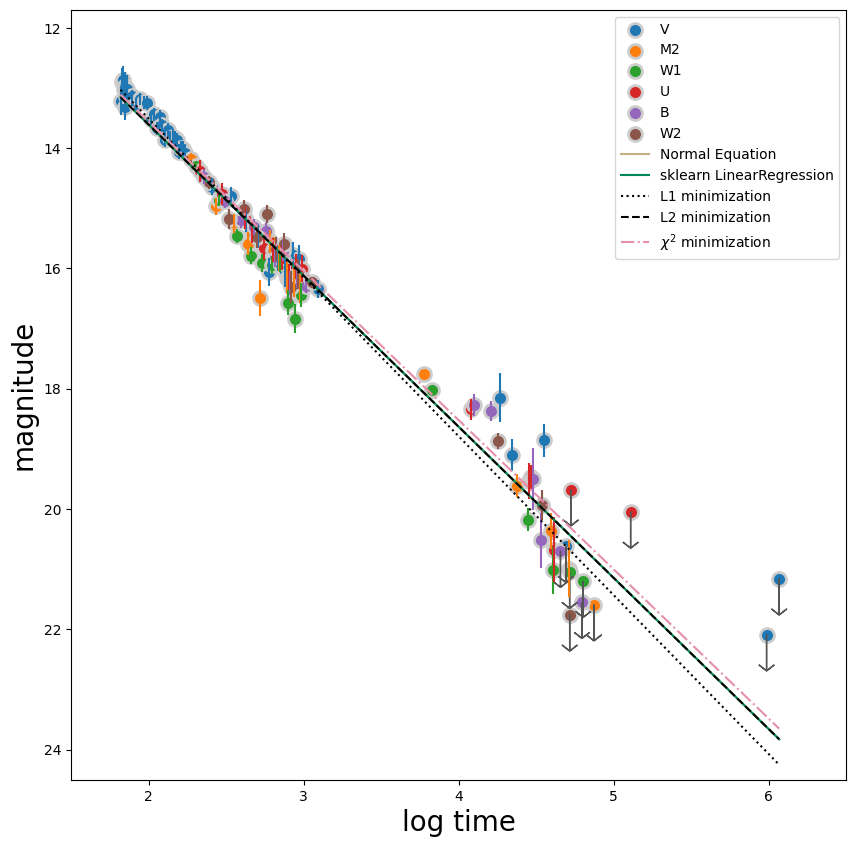

In [19]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);


# RERWITE THIS CAPTION!


**CAPTION**: The figure displays GRB afterglow photometry data (magnitude vs. log time, excluding upper limits; same as Figure 1) overlaid with best-fit linear regression models. These models were derived through analytical solutions of the normal equations, sklearn’s LinearRegression, and numerical minimization of L1 and chi-squared objective functions, as indicated in the legend. Interestingly, the slopes of all models are nearly identical, particularly between sklearn and L2 minimization, suggesting that a single power-law decay is pretty good at describing the data in log-log space and validates the consistency of the fitting methods.


# HW part 2: redo the sklearn model with a train-test split of the data

- choose the train-test rations that you prefer
- get the score for the model when predicting on the train data and on the test data
- what can you say about the model by comparing the two scores?

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((91, 2), (91,), (17, 2), (17,))

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(f"score on the training set {lr.score(X_train, y_train):.2f}")
print(f"score on the training set {lr.score(X_test, y_test):.2f}")

score on the training set 0.97
score on the training set 0.96


The score is the same for the training and test set. This means that we are not overfitting the data and the model is transferable to unseen data. Furthermore the score is high: the model explains 97% of the variance which is remarkably good!

# Now try a line to the data with MCMC

# HW part 3: write captions for each figure. The figures are produced by my code. The captions should state:
- what is plotted
- what is noticeable or interesting in the figure



In [22]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.6 MB/s eta 0:00:00


In [23]:
import emcee #import the package - please move this to the top with the other imports!

In [24]:
emcee

<module 'emcee' from '/usr/local/lib/python3.12/dist-packages/emcee/__init__.py'>

look at documentation: https://emcee.readthedocs.io/en/stable/

We are implementing Bayes theorem to find the best model parameters:

$P(\theta | D) ~ P(D | \theta) * P(\theta)$

or

_Posterior ~ Likelihood * Prior_

Since we are maximizing the likelihood, we work in log space because:
- the logarithm is a monotonic function of its argument (meaning where the argument gets bigger its log gets bigger, where it gets smaller its log gets smaller)
- the log is not defined for negative values (log(something < 0) is undefined) but this does not matter because the likelihood is a probability and probabilities are positive defined.



# Below i develop the line model and find the posterior with MCMC. Your task is to do the same for a different model. the Broken Power Law

In [25]:
# LINE MODEL
def log_prior(theta):
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0
  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf


In [26]:
#log likelihood
def log_likelihood(theta, x, y, yerr):
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)

In [27]:
#log posterior
def log_posterior(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood(theta, x, y, yerr)

In [28]:
#initial guess
ig = [1,10]

In [29]:
#initialize N walkers
nwalkers = 32
ndim = len(ig)

In [30]:
#the starting point for each walker is a small perturbation of the initial guess
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

In [31]:
pos.shape

(32, 2)

In [32]:
# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, s))

In [33]:
# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 1_000, progress=True); #progress=True show the dynamic percentage bar

100%|██████████| 1000/1000 [00:02<00:00, 491.19it/s]


In [34]:
# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

In [35]:
samples.shape

(1000, 32, 2)

In [36]:
samples.transpose(1,0,2)[:,:,0].shape

(32, 1000)

Text(0, 0.5, 'Slope')

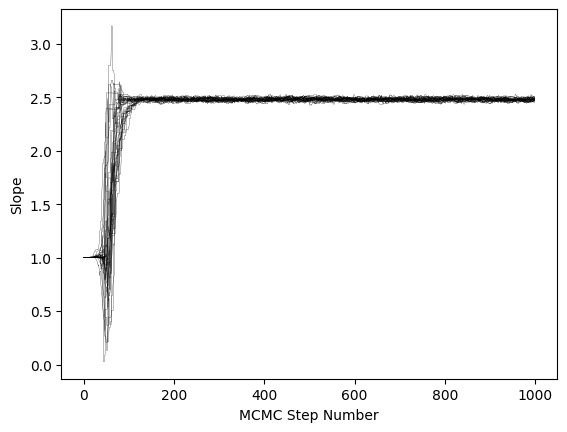

In [37]:
for i in range(ndim):
    pl.plot(samples[:,:,0], 'k', lw=0.1, )
pl.xlabel("MCMC Step Number")
pl.ylabel("Slope")

**CAPTION:** This plot shows the MCMC walker plot over 1000 steps. It uses 32 walkers. They all converge to a slope of abour 2.5 after traversing 1000 steps which suggesting that the same distribution is agreed upon.

to get statistical properties of the chains I will concatenate the 32 chains.
This works _iff_ the chains are independent - see about it in the slides!

note: the chains are _assumed_ to be independent


the first 100 points are where the chains are "burning in" and we will throw them away (`discard=100`) - see slides!!
`flat=True` does the concatenation


In [38]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian


In [39]:
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile(flat_samples[:,i], [16, 50, 84])

print(f"slope {mcmc[0][1]:.2f} [{mcmc[0][0]:.2f}-{mcmc[0][2]:.2f}]")
print(f"intercept {mcmc[1][1]:.2f} [{mcmc[1][0]:.2f}-{mcmc[1][2]:.2f}]")

slope 2.48 [2.46-2.49]
intercept 8.60 [8.56-8.64]


plotting the likelihood space: the panels are 2D projections of the feature space and 1D marginalized probabilities for each parameters


In [40]:
!pip install corner


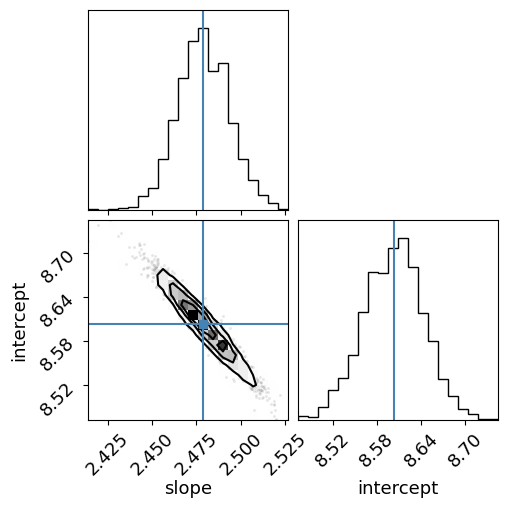

In [41]:
import corner
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["slope", "intercept"], truths=mcmc[:,1]);


WRITE YOUR OWN CAPTION HERE!

**CAPTION**: This plot shows the MCMC results for the slope and intercept of the linear model. It’s a corner plot with histograms on the diagonal and scatter plots off-diagonal, where the best-fit values (from the median of the MCMC run) are marked with lines. It conveys how uncertain the parameters are and how they might be related, which is useful for checking if the model fits the data well.

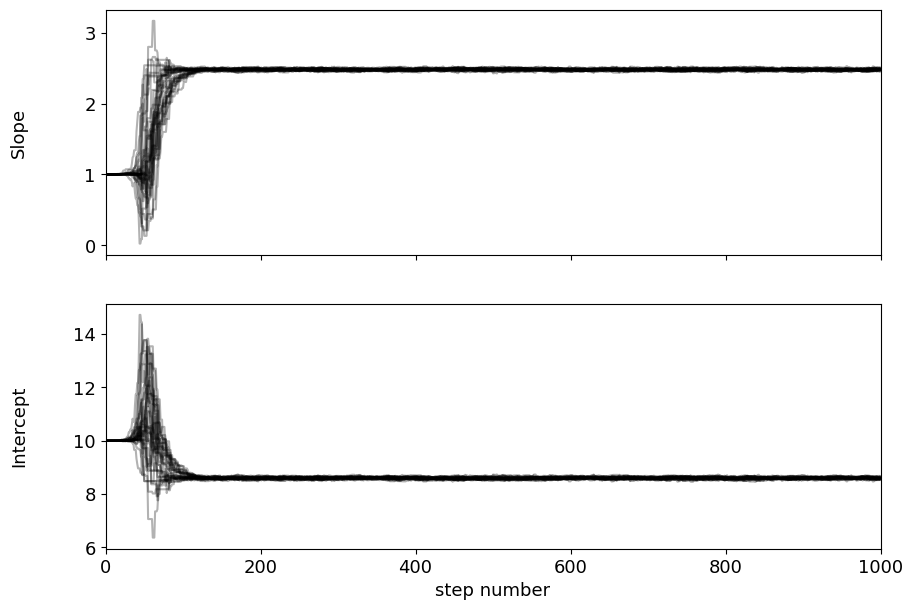

In [42]:
# the chains should be plotted as well. here is a better plot of the chains
#in the slides and in class I discussed what you should expect them to look like
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
axes[1].set_ylabel("Intercept")
axes[0].set_ylabel("Slope");

**CAPTION:** This plot shows a stacked visualization of MCMC chains for the intercept and slope parameters across 1000 steps. The traces suggest that both parameters stabilize and converge after a similar number of initial steps (around 100).

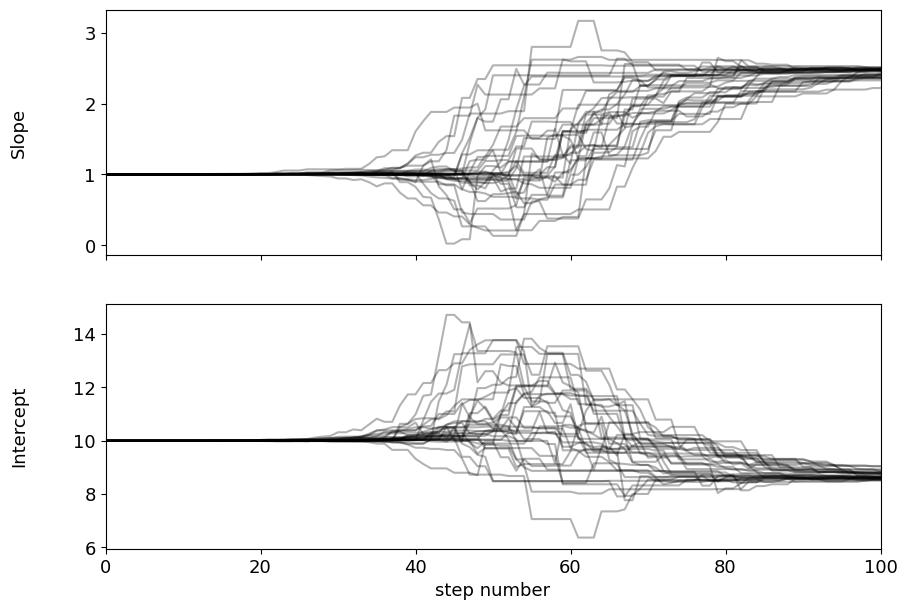

In [43]:
# zoom in: the beginnign of the chane should be cut - this is the burn-in part of the chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
axes[1].set_ylabel("Intercept")
axes[0].set_ylabel("Slope");

**CAPTION:** The subplots above represent a close-up version of the plots above (burn-in), except it is just the first 100 steps instead of the entire 1000.

In [44]:
# save the mcmc results for later
mcmc_line = mcmc
mcmc_line

array([[2.46469708, 2.47884564, 2.49331717],
       [8.5616835 , 8.60373007, 8.64265212]])

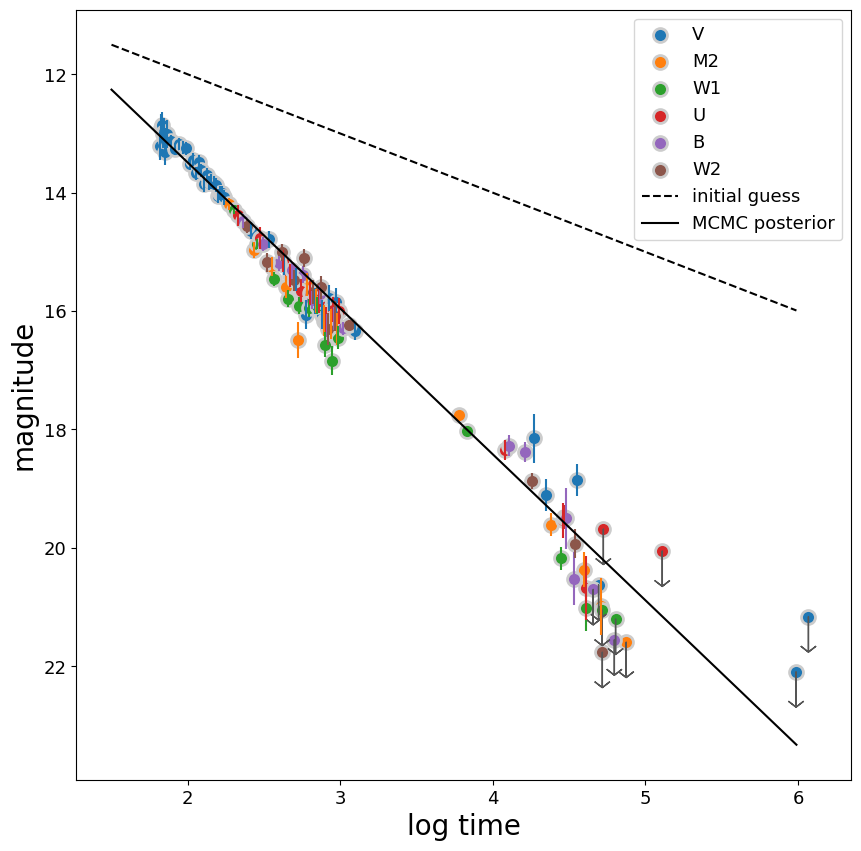

In [45]:
labels = ["intercept","slope"]
ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(np.arange(1.5,6,0.01),
        line(10, 1, (np.arange(1.5,6,0.01))),
        #line(ig[1], ig[0], 10**np.arange(1.5,6,0.01)),
        ls="--", c="k",
        label="initial guess")

ax.plot(np.arange(1.5,6,0.01),
        line(mcmc_line[1][0], mcmc_line[0][0], np.arange(1.5,6,0.01)),
        ls="-", c="k",
        label="MCMC posterior")

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

#pl.ylim(24.5,11.7)
#pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

**CAPTION:** This plot displays the photometry of the GRB052505 A afterglow as a function of time elapsed since the explosion. Various photometric bands are represented by distinct colored points, with their corresponding details provided in the legend. Each data point includes an error bar or an upper limit. The magnitudes are graphed against log(time) from the explosion, with the MCMC initial guess and posterior fitted line overlaid.

# HW part 3

# Now try a broken power law (BPL) model

A power la is not a good model for GRB afterglows. A broken power law has been known to be a better model and has several physical motivations. In this exercise you will fit a _broke power law_ to the data, which is a more complex and higher dimensional model than the simple line fit we did so far, with MCMC getting best values for the posterior, a complete characterization of the likelihood, and allowing model selection between the line and the power law.

> Here is some info that talks about the power law model and the phsyics of GRB, which you need not know to solve the assignment but you may be interested in.  A broken power law is a power law ($y ~ x^a$) where the power a changes at some point. This can be caused by the presence of two power law processes with different, for example, where one dominates at early time and the other at late times.


>> Here is some more info that explains why we observed the GRB afterglows as broken power laws.
>>Gamma-ray bursts (GRBs) are produced by the collapse of massive stars or the merger of compact objects like neutron stars. The energy of the collapse is highly energetic (Gamma rays) but the emission gets reprocessed as it leaves the system and looses energy becoming detectable in the optical wavelengths. This is called the "optical afterglow of the GRB".
>>The explosion resulting from the collapse generates a highly relativistic outflow of material that moves at a significant fraction of the speed of light.
>> The afterglow emission is primarily produced through synchrotron radiation, where charged particles spiral around magnetic field lines. The radiation produced by synchrotrone follows a power law with an index that depends on the density of the surrounding medium, the Lorentz factor of the outflow, and the magnetic field strength. As the radiation crosses different regions of the system that collapsed these factors change and the powerlaw index changes with them.

>>If the relativistic outflow is highly collimated (a jet) as the jet expands, its emission can be modeled as a power-law light curve, but  where the jet begins to decelerate and spread out the slope of the power law changes. This transition is known as the "jet break" and results in a broken power-law behavior.

>> Some GRBs exhibit late-time flares or additional energy injection from the central engine but we are not modeling this in this exercise.




_BPL model variables:_

$F = \mathrm{flux}$ - note: not magnitude this time! $mag ~ -2.5log10(Flux)$

$t =  \mathrm{time}$ - note: not log time

_BPL model parameters:_


$T_b =  \mathrm{Time~of~break}$

$a_1:  \mathrm{Early~slope}$

$a_2: \mathrm{Late~slope}$

$b:  \mathrm{nuisance~parameters}$

_BPL model_:

in flux space the BPL model is:
$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$

in magnitude space (the data you want to predict is in magnitude and the equation is simple to minimize in log space) that is:

$mag = b - log_{10}\left((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2})\right) $



In [46]:
# NOTE: this model is not in log time!!
t = grbAGnouplim.time.values

In [47]:
t.min(), t.max()

(np.int64(66), np.int64(51257))

# HW part 3 task 1:
create the model `bpl()`, the `log_likelihood()`, `log_prior()` (choose what you want to set your prior to), and `log_posterior()`

In [48]:
print(t.min(), t.max())

66 51257


In [49]:
def bpl (theta, x):
    """broken power law model
    Input:
      theta: (array like) 4 parameters vector, see equation
      x: (array like) independent variable (time)
    Return:
      model predictions for each x (array like)
    """

    Tb, a1, a2, b = theta
    term = ((x/Tb)**(-a1) + (x/Tb)**(-a2))
    return b - np.log10(term)


In [50]:
def log_likelihood_bpl(theta, x, y, yerr):
  # use the same log_likelihood as before (chi2) but with the new model
  model = bpl(theta, x)
  return -(1/2) * np.sum(((y-model)**2) / yerr**2)


def log_prior_bpl(theta):
  Tb, a1, a2, b = theta
  if 60 < Tb < 55000 and a1 > 0 and a2 > 0 and 10 < b < 30:
    return 0
  return -np.inf


def log_posterior_bpl(theta, x, y, yerr):
  #this is the same as before! exactly! cause this is just log_likelihood + log_prior
  lp = log_prior_bpl(theta)
  likelihood = log_likelihood_bpl(theta, x, y, yerr)
  if not np.isfinite(lp):
    return -np.inf
  return lp + likelihood

# HW part 3 task 2:
Find the initial starting point as a stochastic gradient descent minimization of the log likelihood

In [51]:
minimize?

In [52]:
def neg_log_posterior_bpl(theta, x, y, yerr):
    lp = log_prior_bpl(theta)
    likelihood = log_likelihood_bpl(theta, x, y, yerr)
    if not np.isfinite(lp):
        return np.inf
    return - (lp + likelihood)

In [53]:
ig = [1000, 5, 0.02, 20]
#what does the minimize function need to take as arguments?
soln = minimize(neg_log_posterior_bpl, ig, args=(t,grbAGnouplim.mag,grbAGnouplim.magerr))
soln

/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 108.73265736203501
        x: [ 2.736e+02  2.146e+00  3.548e+00  1.505e+01]
      nit: 56
      jac: [ 2.098e-05  3.583e-03  4.406e-04 -4.128e-03]
 hess_inv: [[ 6.038e-02 -5.798e-04  2.033e-02  1.854e-03]
            [-5.798e-04  6.327e-04 -9.354e-04 -2.793e-04]
            [ 2.033e-02 -9.354e-04  7.818e-03  9.176e-04]
            [ 1.854e-03 -2.793e-04  9.176e-04  3.639e-04]]
     nfev: 704
     njev: 134

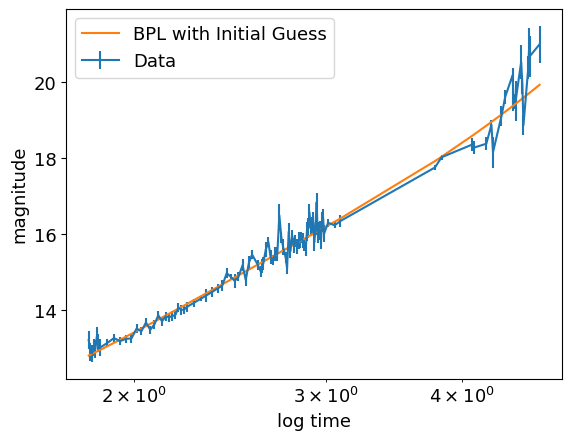

In [54]:
ig = soln.x # the initial guess for the MCMC

plt.errorbar(x, y, yerr=s, label='Data')
plt.plot(x, bpl(ig, t), label='BPL with Initial Guess')
plt.xscale("log")
plt.xlabel("log time")
plt.ylabel("magnitude")
plt.legend()
plt.show()


(This plot is just here for me - I have a caption for the plot below)

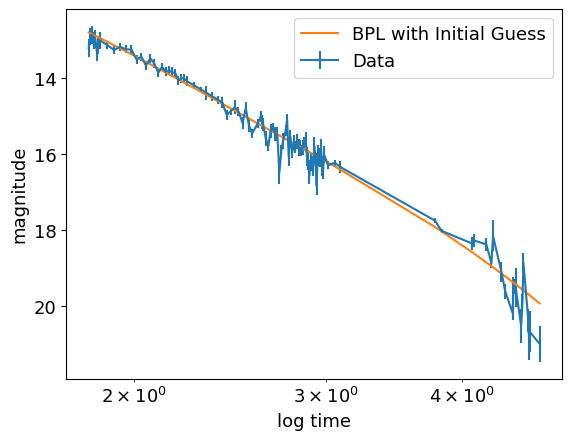

In [55]:
ig = soln.x # the initial guess for the MCMC
# added inversion so it makes more sense
plt.errorbar(x, y, yerr=s, label='Data')
plt.plot(x, bpl(ig, t), label='BPL with Initial Guess')
pl.xscale("log")
pl.ylabel("magnitude")
pl.xlabel("log time")
ax = pl.gca()
ax.yaxis.set_inverted(True)
ax.legend()

**CAPTION**: This plot depicts the GRB afterglow following the explosion, featuring observed photometry data (blue error bars) and a fitted broken power law model (orange line) plotted against log time. The y-axis is inverted to position brighter magnitudes (lower values) at the top, improving physical intuition as the afterglow dims over time. Minimization indicated that the shift to a slower decay rate occurs approximately 274 seconds after the explosion, likely influenced by physical processes.

# HW 3 task 3: optimize the model wit MCMC

- set the emcee hyperparameters
- run the chains
- extract the statistical properties of the chain as the best fit values
- plot the model
- plot the marginalized posteriors of the model parameters

In [56]:
# set the emcee hyperparameters
np.random.seed(67)
ig = [273.6, 2.15, 3.55, 15.05]
nwalkers, ndim = 32, 4
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_bpl, args=(t, y, s))

In [57]:
# run the model
sampler.run_mcmc(pos, 1_000, progress=True)

 16%|█▌        | 161/1000 [00:01<00:07, 113.46it/s]/tmp/ipython-input-3826130534.py:11: RuntimeWarning: invalid value encountered in power
  term = ((x/Tb)**(-a1) + (x/Tb)**(-a2))
100%|██████████| 1000/1000 [00:06<00:00, 161.81it/s]


State([[309.94071765   2.1150424    3.44037044  15.21717769]
 [319.10823805   2.12309415   3.43646747  15.22712046]
 [340.83995207   2.07840599   3.43181629  15.31783353]
 [267.49207079   2.15532908   3.48348097  15.02060099]
 [302.8828524    2.13553002   3.44690653  15.15584094]
 [243.57289291   2.179622     3.50953106  14.88229238]
 [351.99857375   2.09939361   3.56665505  15.36451825]
 [180.51279972   2.22155933   3.74075286  14.53244381]
 [405.24722871   2.09352741   3.32362486  15.46734334]
 [309.57441423   2.15748028   3.56479202  15.2049432 ]
 [310.2844196    2.13834307   3.4011563   15.17088427]
 [300.68515224   2.10530615   3.57421973  15.18881836]
 [229.47315371   2.1784242    3.54523833  14.80839136]
 [330.44029402   2.10103373   3.47846405  15.27268302]
 [354.20012376   2.09907164   3.42708323  15.36834348]
 [207.82673729   2.21589678   3.65928089  14.69413709]
 [294.8289111    2.14035994   3.46531023  15.12449392]
 [261.41340609   2.16017559   3.62576681  15.00155417]
 [32

Text(-0.1, 0.5, 'Nuisance Parameter')

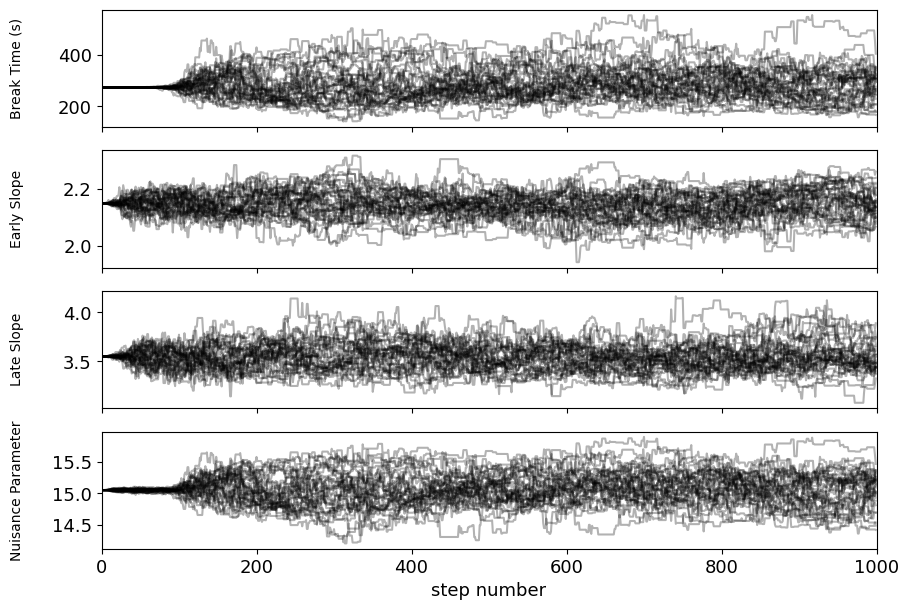

In [58]:
#plot the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
axes[0].set_ylabel("Break Time (s)", fontsize=10)
axes[1].set_ylabel("Early Slope", fontsize=10)
axes[2].set_ylabel("Late Slope", fontsize=10)
axes[3].set_ylabel("Nuisance Parameter", fontsize=10)

**CAPTION:** This plot displays the MCMC walker plots for the broken power law model parameters - Break Time (s), Early Slope, Late Slope, and Nuisance Parameter over 1000 steps. The traces, shown as black lines illustrate how the 32 walkers explore the parameter space. Although the walkers do get a bit noisy, they don't diverge far from the inital guesses suggesting the minimaztion was pretty acurrate!

In [59]:
# get the 16th, 50, and 84th percentiles of the model parameters
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
    mcmc[i] = np.percentile(flat_samples[:,i], [16, 50, 84])
mcmc[:,1]

array([277.29534165,   2.14449093,   3.53532378,  15.0648301 ])

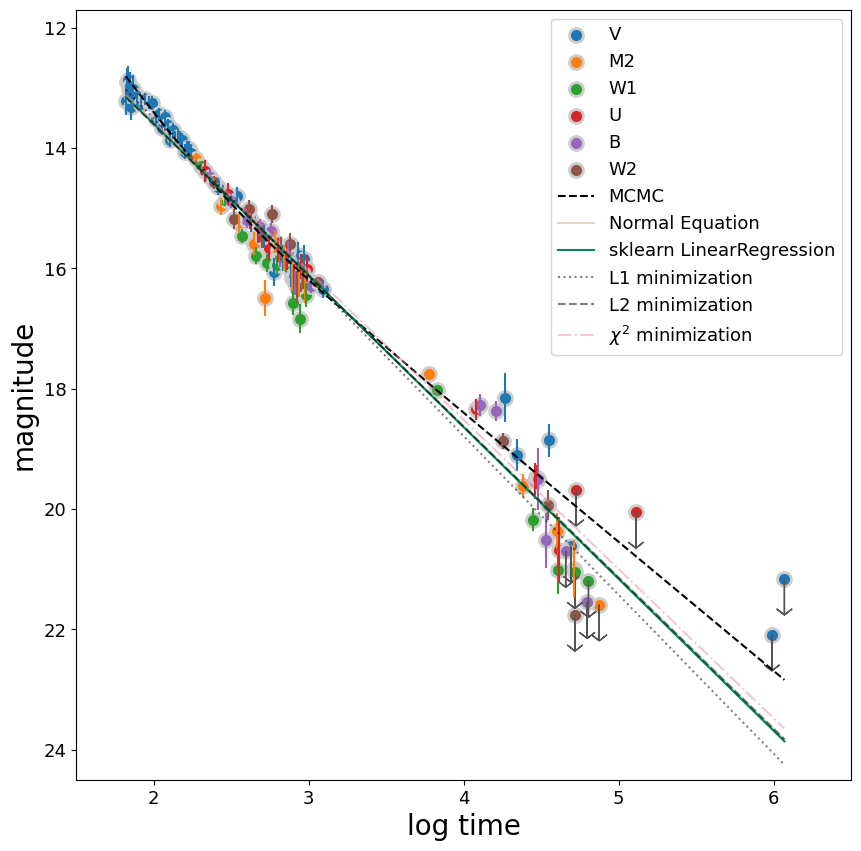

In [60]:
#plot the model
ax = plotlogtime(grbAG)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(grbAG.logtime.values, bpl(mcmc[:,1], grbAG.time.values), ls="--", c="k", label="MCMC")
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],  alpha=0.5,
         label="Normal Equation", ax=ax)
#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':', alpha=0.5,
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--', alpha=0.5,
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.', alpha=0.5,
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
# pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.axvline(np.log10(mcmc[2,1]))
pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

**CAPTION**: This graph mirrors the earlier GRB magnitude versus time plots, now enhanced with the BPL MCMC-optimized fitted curve. Important to note is the change in slope is evident around log(time) = 2.4, aligning with the break time. The BPL fit seems to track the data points more closely than the prior five fitting methods, owing to its greater flexibility and advanced modeling capabilities.

## plot the marginalized posterior distributions of the parameters

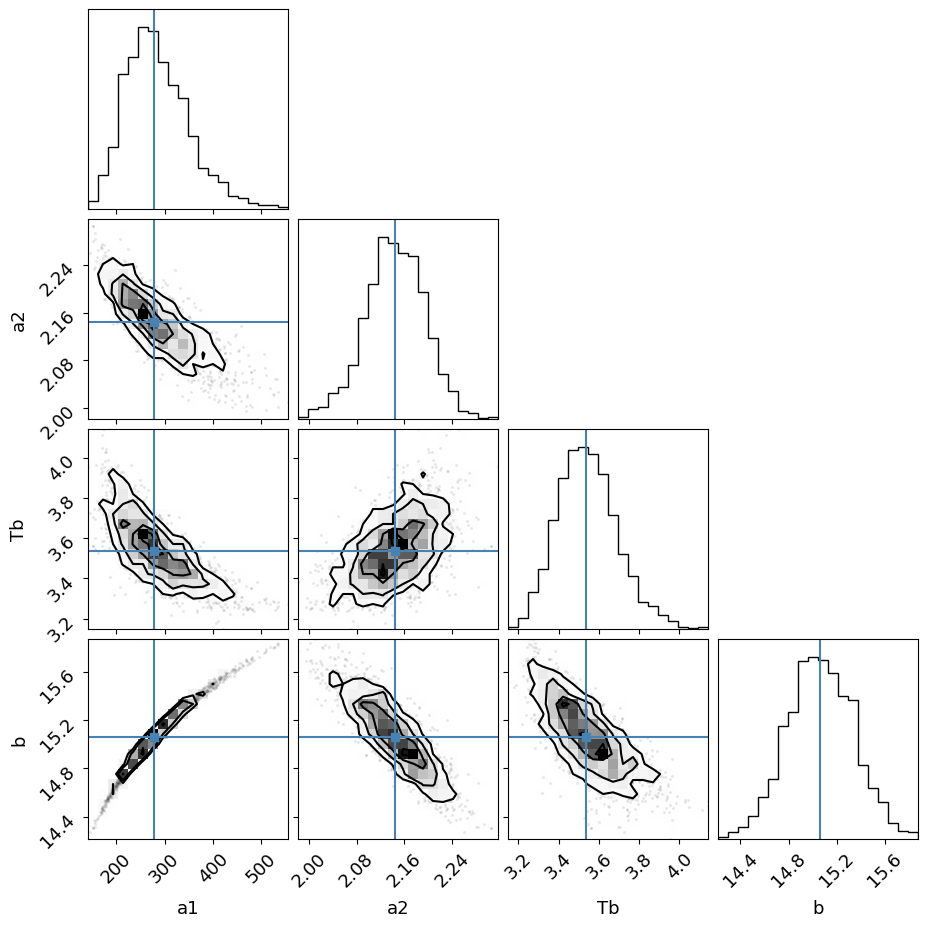

In [61]:
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["a1", "a2", "Tb", "b"], truths=mcmc[:,1]);

**CAPTION**: This plot displays the MCMC results for the broken power law model parameters: a1, a2, Tb, and b. It’s a corner plot with histograms on the diagonal and scatter plots off-diagonal, showing the best-fit values (from the median of the MCMC run) as lines. The visualization highlights the uncertainty of each parameter and their potential correlations.

EXTRA CREDIT FOR 461 REQUIRED FOR 661

# HW part 4: Compare the line (as obtained by the MCMC) and broken power law models. For this part of the assignment use the slides in https://slides.com/d/Ql12kB4/live#/11. in particular:

- Print the loglikelihood of each model (you can use the log_likelihood function you had written for each)


- implement the calculation of the likelihood ration, which is expected to be chisq distributed following a chisq distribution with k degrees of freedom where k is the difference in number of parameters.

- implement the caluculation of the AIC (https://slides.com/d/Ql12kB4/live#/11/6
- and BIC (https://slides.com/d/Ql12kB4/live#/11/8)



In [62]:
print(f"Log likelihood of line model: {log_likelihood(mcmc_line[:,1], x, y, s):.2f}") #control the decimal digits!

Log likelihood of line model: -317.43


In [63]:
print(f"Log likelihood of BPL model: {log_likelihood_bpl(mcmc[:,1], t, y, s):.2f}")

Log likelihood of BPL model: -108.75


## Implement the likelihood ratio test printing out the likelihood ratio statistics https://slides.com/d/Ql12kB4/live#/11/2

The likelihood-ratio test assesses the goodness of fit of two competing _nested_ statistical models based on the values of the likelihood $L$ where $M1$ is the restricted model (the parameter space is smaller, hence restricted), nested inside $M2$, the full model (the more complex one).

$ \lambda_\mathrm{LR}=-2\ln {\frac {L(M1(\theta_\mathrm{restricted}))}{L(M2(\theta_\mathrm{full}))}}$

This statistics is expexted to be $\chi2$ distributed following a $ch2$ distribution with d.o.f=difference in size of the parameter space in the two models (number of parameters in bpl model - number of parameters in line model).


In [64]:
def like_ratio_statistics(log_likelihood_restr, log_likelihood_full):
  return -2 * (log_likelihood_restr - log_likelihood_full)

# CHOOSE THE BEST MODEL IN THE NHRT FRAMEWORK


write out the first 4 steps of the NHRT:
- state the null
- state the alternative
- choose the threshold
- choose the test (OK, I did that for you!)
- measure the test statistics (pivotal quantity)
- get the p-value

_see if you can get the p-value from the table
I WILL NOT TAKE POINTS OFF IF YOU GET IT WRONG, but I want you to try and figure out how to read the table in https://slides.com/d/Ql12kB4/live#/11/2 to get a p-value out of your likelihood ratio statistics. Try your best!_

- use that p-value to see if you can or cannot reject the null and clearly state your conclusions




- NULL: The line model is sufficient to fit the GRB afterglow data, and the BPL model does not provide a significantly better fit.
- ALT: The BPL model fits the GRB afterglow data significantly better than the line model.
- THRESHOLD: p = 0.05
- TEST: Likelihood-ratio test

In [65]:
ll_line = log_likelihood(mcmc_line[:,1], x, y, s)
ll_bpl = log_likelihood_bpl(mcmc[:,1], t, y, s)

likelihood_ratio = like_ratio_statistics(ll_line,ll_bpl)

In [66]:
print(f"The likelihood ratio is: {likelihood_ratio:.2f}")
pval = sp.stats.chi2.sf(likelihood_ratio, 2) # 2 degrees of freedom
print(f"The p-value is: {pval:.2e}")

The likelihood ratio is: 417.36
The p-value is: 2.36e-91


**CONCLUSIONS**: With a p value so small, the null hypothesis is rejected. This means that there is overwhelming evidence that the line model is insufficient and the BPL model is a better fit to the GRB afterglow data.

## Calculate the AIC and BIC: Aikiki Information Criterion and Bayesian Information Criterion for the comparison of the same two models.


In [67]:
def aic(n_o, log_likelihood, n_p):
  return 2 * n_p - 2 * log_likelihood
def bic(n_o, log_likelihood, n_p):
  return n_p * np.log(n_o) - 2 * log_likelihood


In [68]:
n_o = len(x)

In [72]:
print("{0:.2f} - {1:.4f}".format(aic(n_o, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                  aic(n_o, log_likelihood_bpl(mcmc[:,1], t, y, s), 4)))

print("{0:.2f} - {1:.2f}".format(bic(n_o, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                  bic(n_o, log_likelihood_bpl(mcmc[:,1], t, y, s), 4)))

638.85 - 225.4979
644.22 - 236.23


# Extra Credit (Extra for everyone)
 redefine the chi2 that I have written above to take a n deg polynomial, fit it to the data, compare it to the BPL model